# Statistical tests 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Ensure plot qualities 
plt.rcParams['figure.figsize'] = (12,6)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  # Adjust DPI for high-resolution figures

In [3]:
data_path = "/Users/alexzheng/Developer/GitHub/EC331-project/EMH/Data/Bitcoin_data_2024.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
df = df[['Close']]

In [4]:
# Calculate returns
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))*100 # In percentage 
df = df.dropna()

df

,Close,log_return
date,,
2024-01-01 00:01:00,42283,0.035482
2024-01-01 00:02:00,42298,0.035469
2024-01-01 00:03:00,42353,0.129945
2024-01-01 00:04:00,42375,0.051931
2024-01-01 00:05:00,42395,0.047187
...,...,...
2024-12-31 23:55:00,93471,-0.023534
2024-12-31 23:56:00,93469,-0.002140
2024-12-31 23:57:00,93427,-0.044945


In [5]:
# Summary statistics of the log returns
print(round(df['log_return'].describe(), 4))

# Print kurtosis and skewness
print("Kurtosis: ", round(df['log_return'].kurtosis(), 4))
print("Skewness: ", round(df['log_return'].skew(), 4))

count    509363.0000
mean          0.0002
std           0.0756
min          -3.6120
25%          -0.0298
50%           0.0000
75%           0.0302
max           2.6230
Name: log_return, dtype: float64
Kurtosis:  56.7862
Skewness:  -0.4262


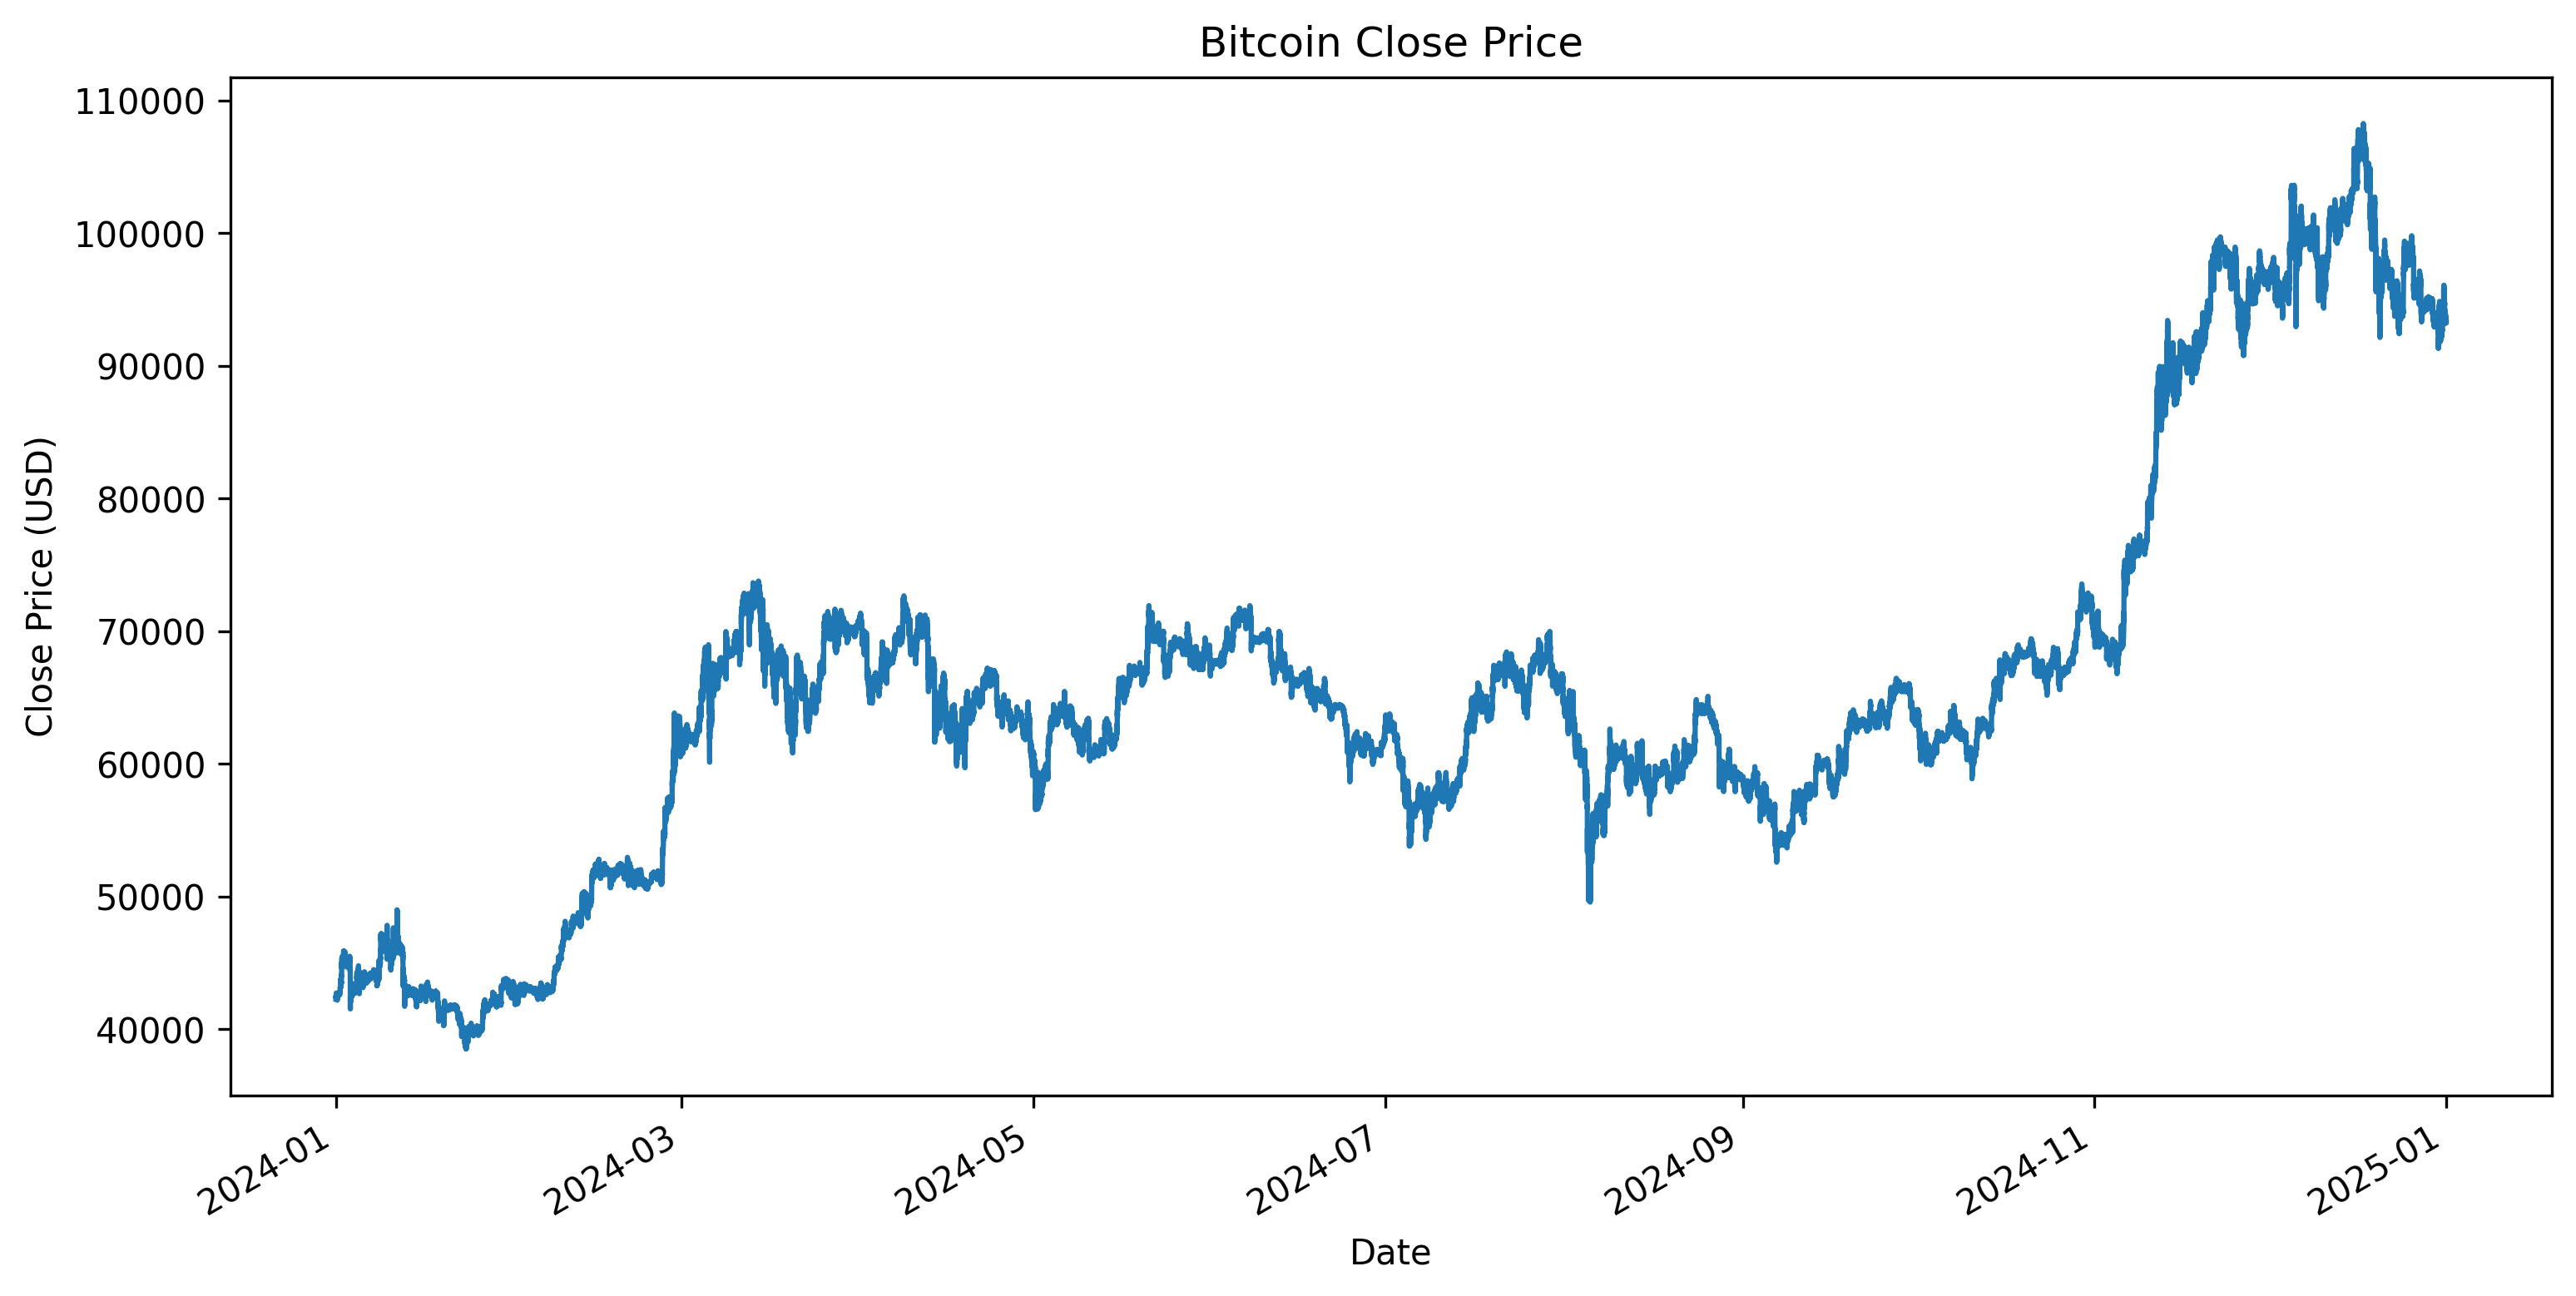

In [6]:
df['Close'].plot()
plt.title('Bitcoin Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()

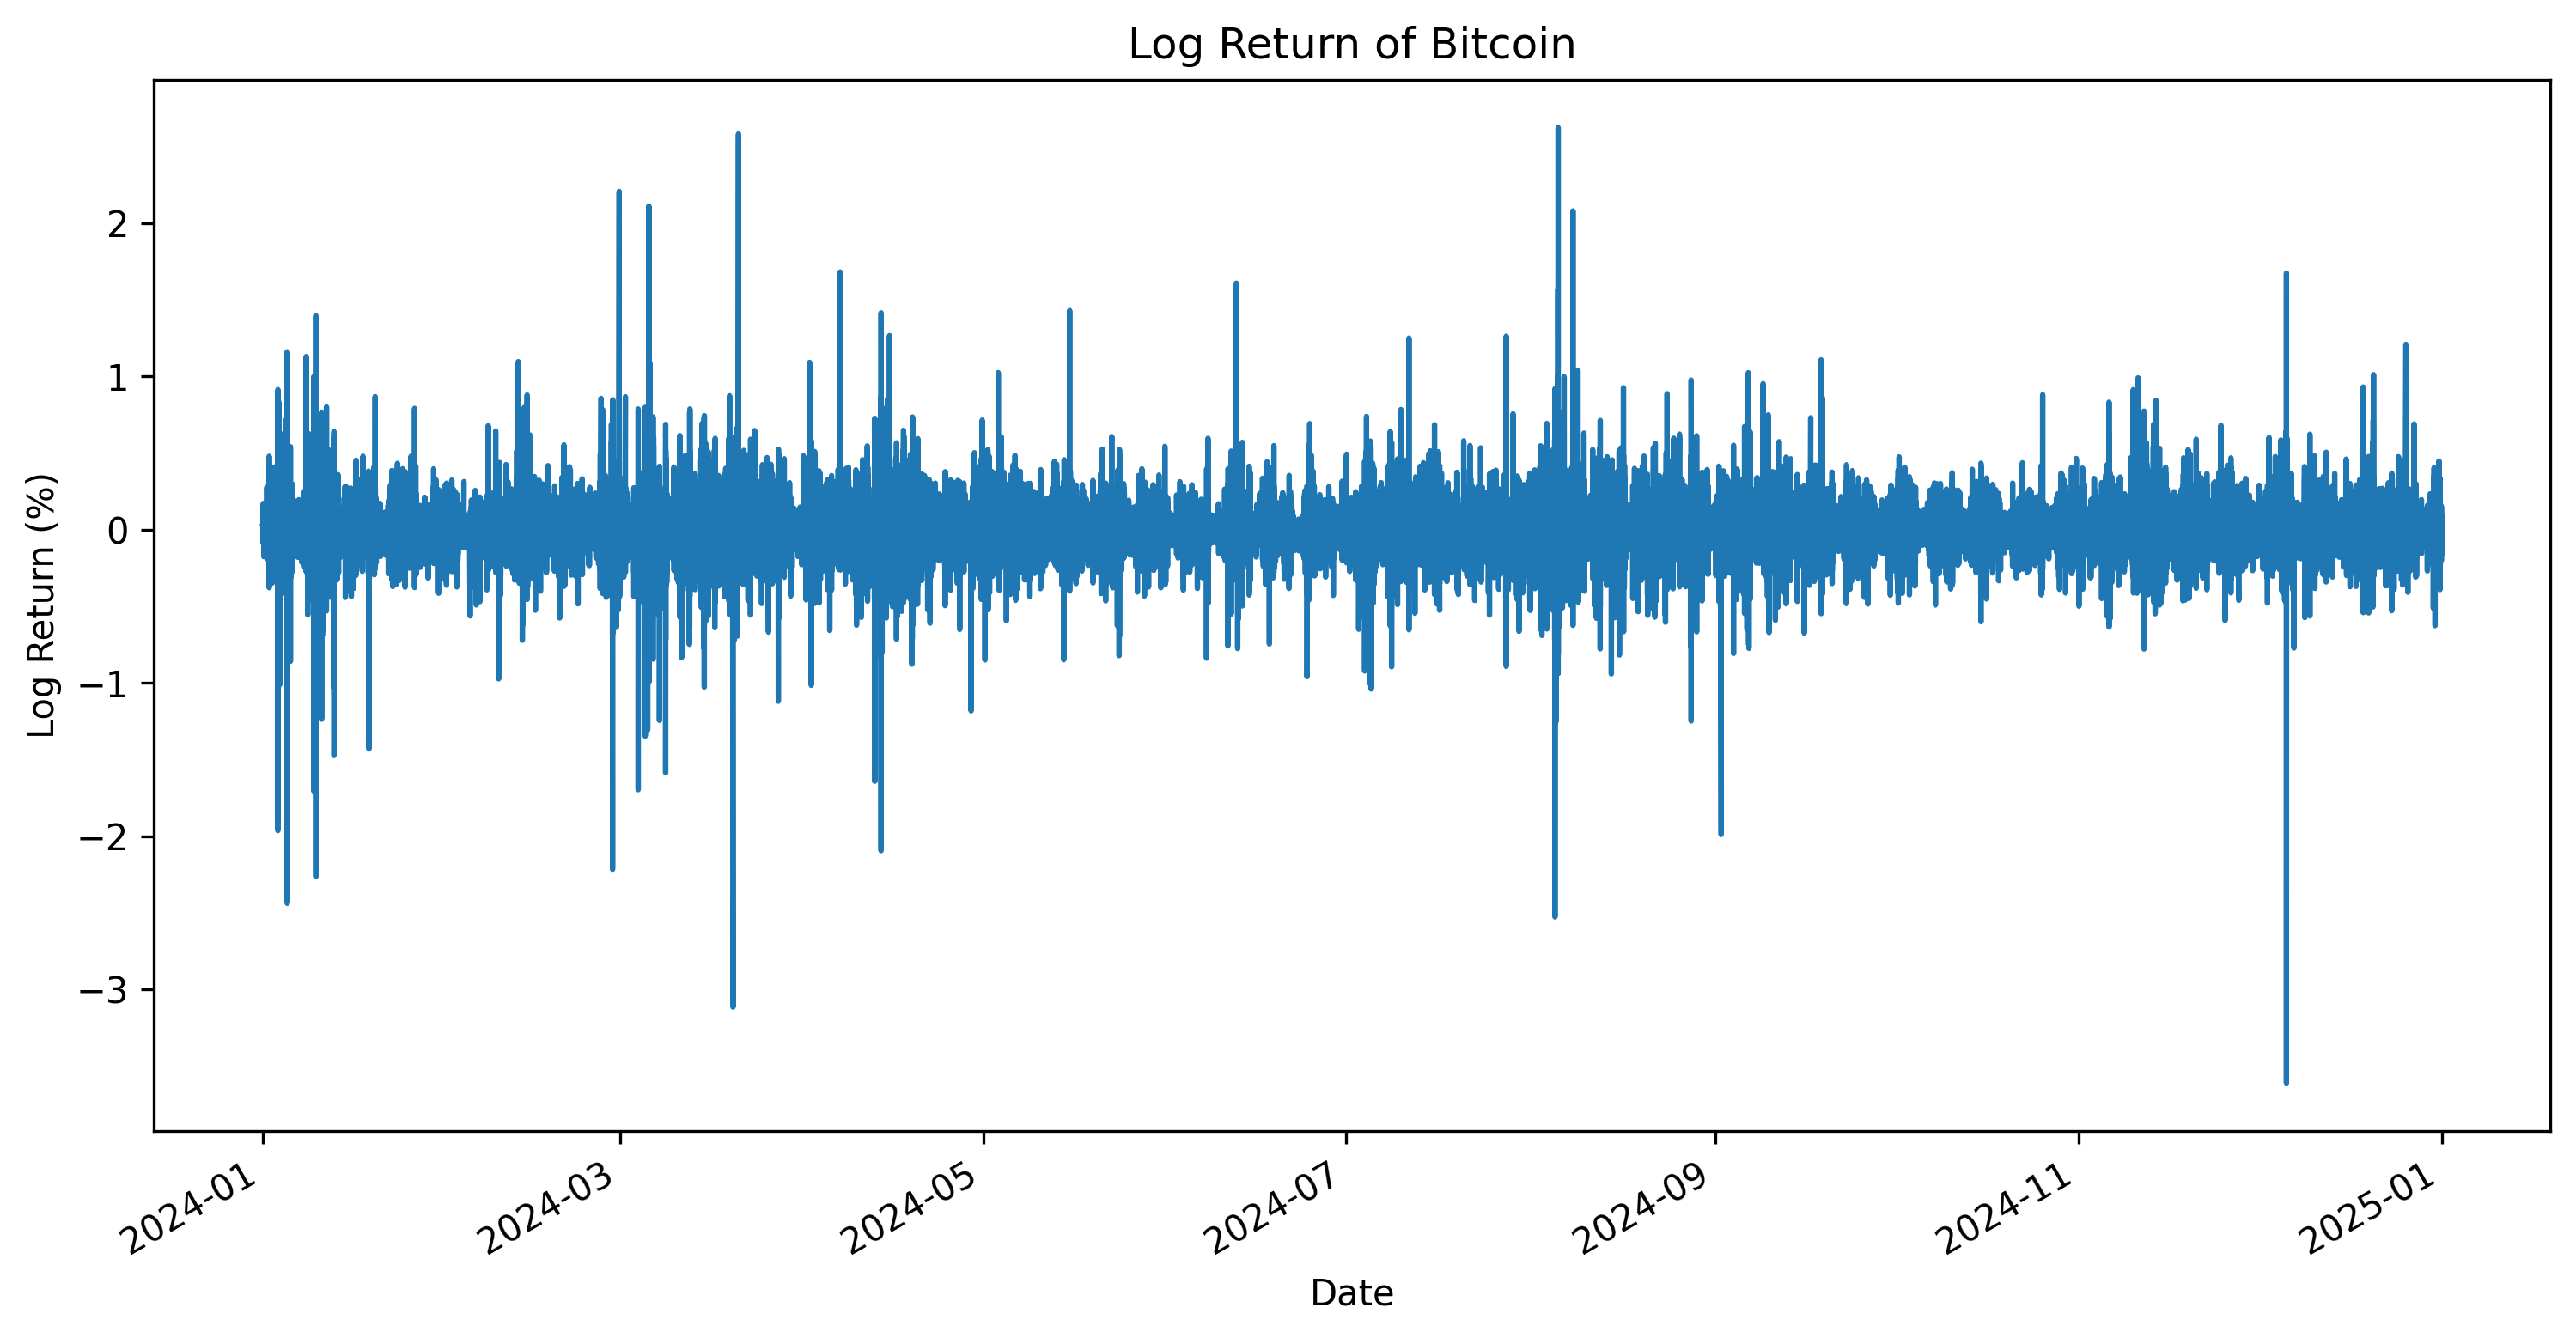

In [7]:
# plt.figure(figsize=(8, 5))
df['log_return'].plot()
plt.title('Log Return of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Log Return (%)')
plt.show()

### Check for normality 

In [8]:
# Perform the Jarque-Bera test
from scipy import stats
from statsmodels.stats.stattools import jarque_bera
jb_test = jarque_bera(df['log_return'])
jb_statistic = jb_test[0]
jb_p_value = jb_test[1]
print("Jarque-Bera statistic: ", jb_statistic)
print("Jarque-Bera p-value: ", jb_p_value)
if jb_p_value < 0.05:
    print("Reject the null hypothesis: The log returns are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: The log returns are normally distributed.")

Jarque-Bera statistic:  68452637.16966338
Jarque-Bera p-value:  0.0
Reject the null hypothesis: The log returns are not normally distributed.


### Check for stationarity 

In [9]:
# Perform ADF Test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['log_return'])

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic: -72.37113744107663
p-value: 0.0
Critical Values:
   1%: -3.4303628407524616
   5%: -2.8615456754616746
   10%: -2.5667730208408917
The series is likely stationary (reject H0).


In [10]:
adf_result

(-72.37113744107663,
 0.0,
 98,
 509264,
 {'1%': -3.4303628407524616,
  '5%': -2.8615456754616746,
  '10%': -2.5667730208408917},
 -1184943.236400674)

### Check for autocorrelation (Ljung-Box test)

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

# Ljung-Box Test (for serial correlation)
ljung_box_results = acorr_ljungbox(df['log_return'], lags=[10], return_df=True)
print(ljung_box_results)

       lb_stat     lb_pvalue
10  159.101146  4.967027e-29


In [12]:
# Results suggest that:
# 1. significant autocorrelation in Bitcoin returns at the 10-lag level (Bitcoin returns do not follow a pure random walk)
# 2. no significant first-order autocorrelation (values close to 2 suggest no autocorrelation)

### Runs Test (check for randomness)

In [13]:
from statsmodels.sandbox.stats.runs import runstest_1samp

# Convert returns into a binary sequence (+1 for positive, -1 for negative)
binary_returns = np.where(df['log_return'] > 0, 1, -1)

# Perform Runs Test
runs_statistic, p_value = runstest_1samp(binary_returns)

# Print results
print(f"Runs Test Statistic: {runs_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretation
if p_value > 0.05:
    print("Bitcoin returns appear random → Supports weak-form EMH.")
else:
    print("Bitcoin returns are not random → Violates weak-form EMH.")

Runs Test Statistic: -6.1007
p-value: 0.0000
Bitcoin returns are not random → Violates weak-form EMH.


In [14]:
# Findings: 
# The Runs Test confirms that Bitcoin’s price movements are not entirely random.

### Variance Ratio Test (heteroskedasticity-robust version)

In [15]:
from arch.unitroot import VarianceRatio

# Apply Variance Ratio Test
vr_test = VarianceRatio(df['log_return'], lags=20, robust=True)
print(vr_test.summary())

     Variance-Ratio Test Results     
Test Statistic                -46.280
P-value                         0.000
Lags                               20
-------------------------------------

Computed with overlapping blocks (de-biased)


In [16]:
# Result suggest that:
# A significantly negative test statistic suggests mean reversion, 
# meaning that returns tend to reverse direction rather than follow a random walk.
# P-value close to 0 -> reject the null hypothesis that Bitcoin follows a random walk.
# Hence, Bitcoin returns do not follow a random walk

### Hurst Exponent (Long Memory Test)

In [17]:
from hurst import compute_Hc

# Compute Hurst Exponent
H, c, data = compute_Hc(df['log_return'], kind='change', simplified=True)
print(f"Hurst Exponent: {H}")

Hurst Exponent: 0.5251316891765195


In [18]:
# Result: 
# Since H is close to 0.5, this suggests that Bitcoin may be weak-form efficient, but not perfectly so.
# Near-random walk, but mild inefficiencies may exist.

### Compute the Rolling Hurst Exponent (check if efficiency is changing over time)

In [19]:
from hurst import compute_Hc

# Set rolling window size
window_size = 10080  # 7 days of minute-level data
stride = 5000  # Skip every 5000 minutes to optimize performance

# Preallocate lists
hurst_values = []
time_index = []

# Compute rolling Hurst exponent efficiently
for i in range(0, len(df) - window_size, stride):
    segment = df['log_return'].values[i:i+window_size]
    H, _, _ = compute_Hc(segment, kind='change', simplified=True)
    hurst_values.append(H)
    time_index.append(df.index[i+window_size])  # Store corresponding time index

# Convert to DataFrame for easy plotting
hurst_df = pd.DataFrame({'Time': time_index, 'Hurst': hurst_values}).set_index('Time')

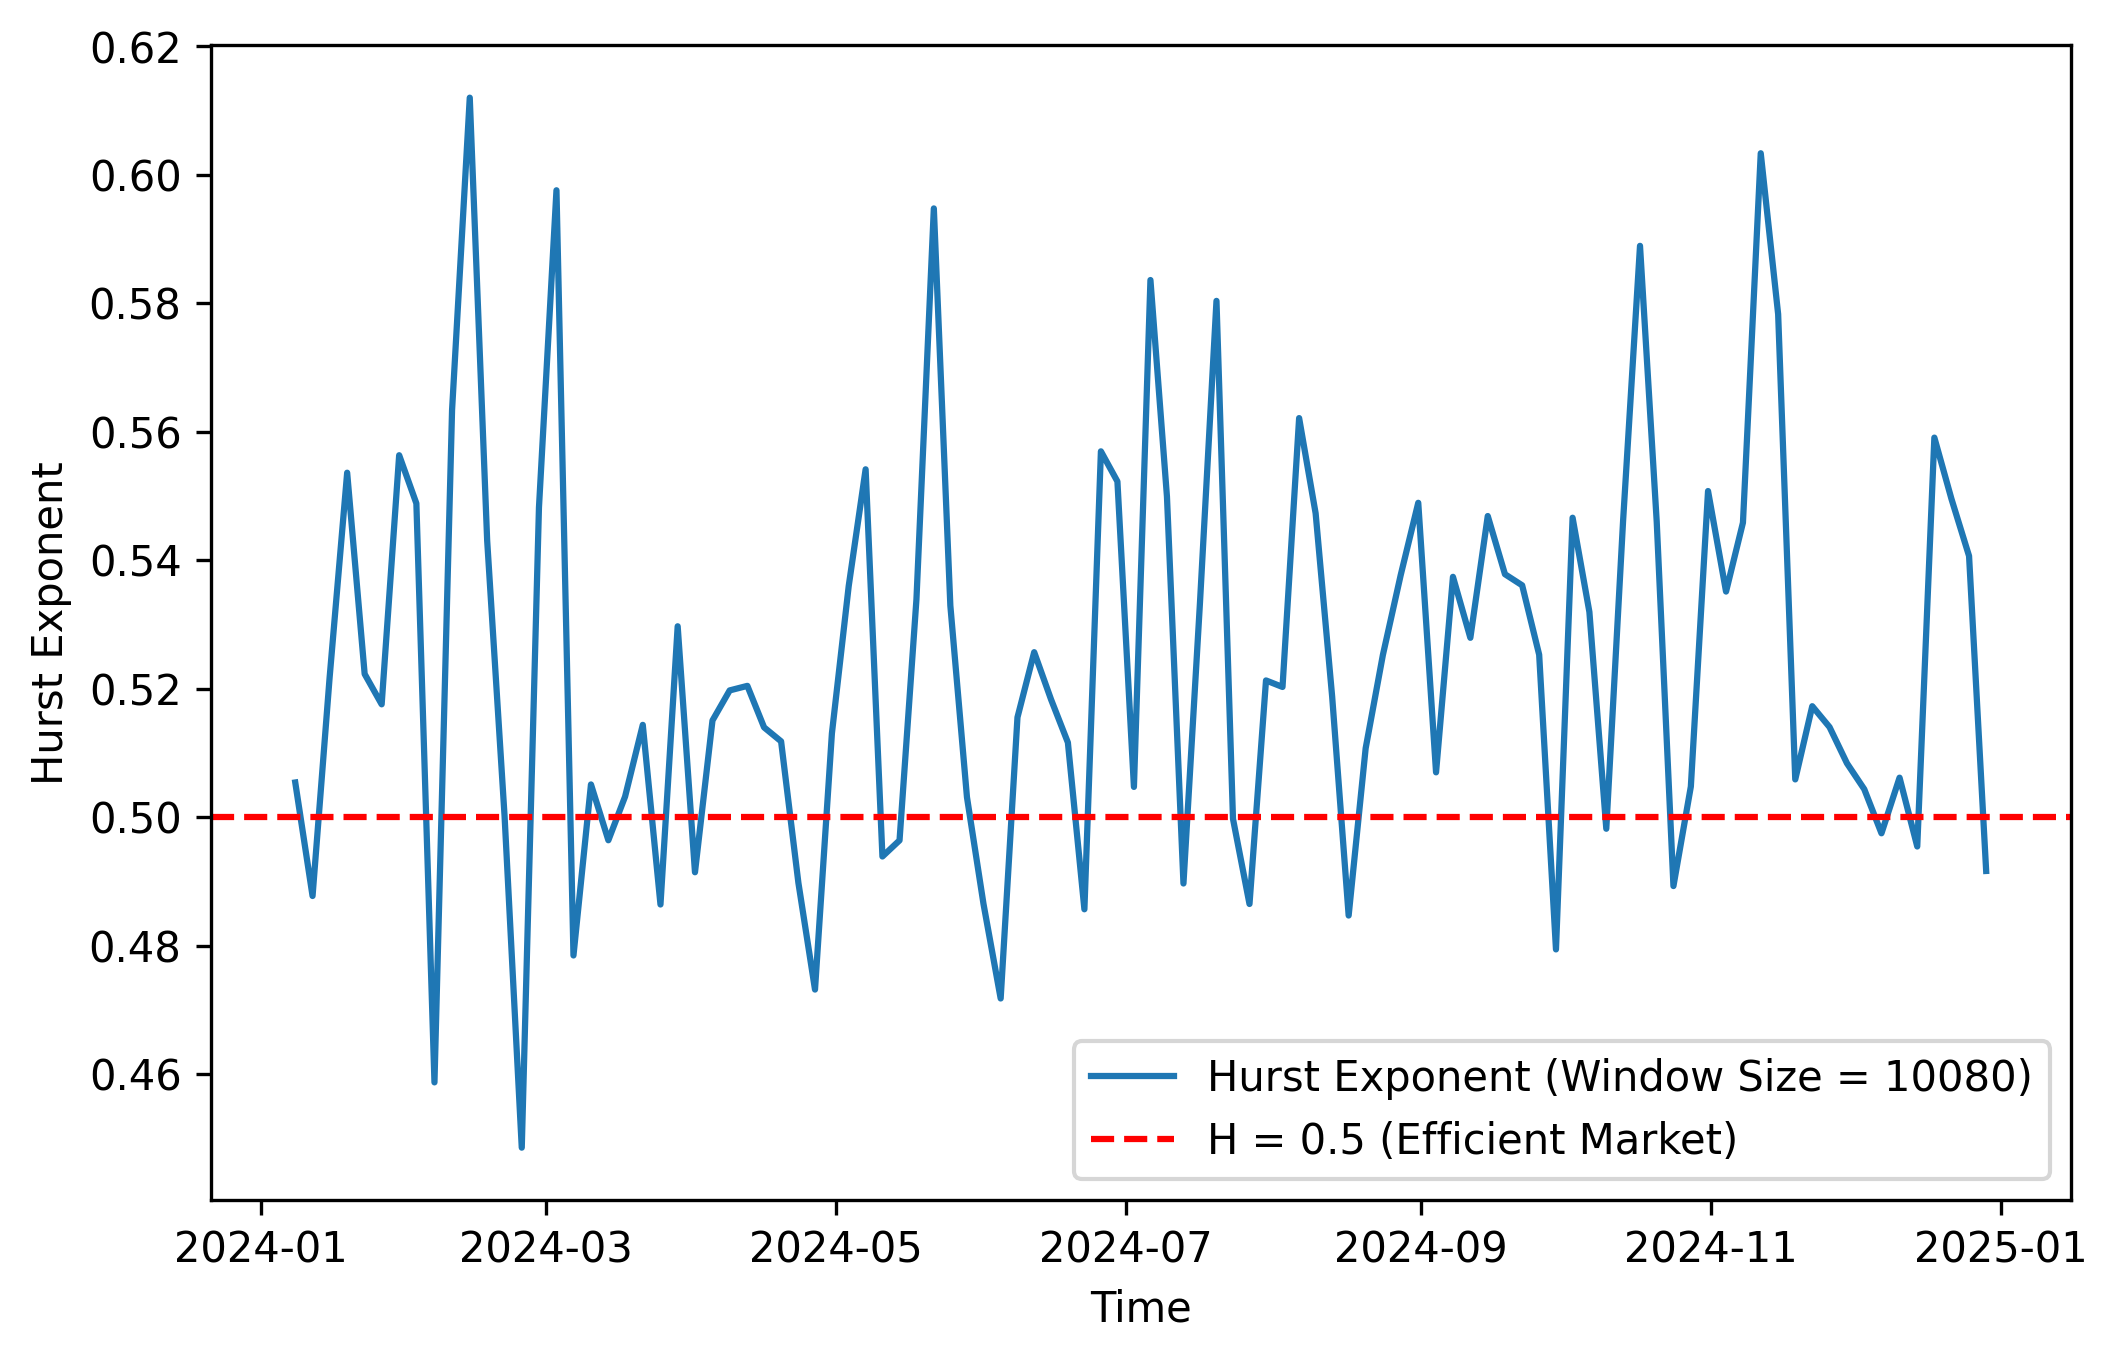

In [31]:
# Plot Rolling Hurst Exponent
plt.figure(figsize=(8, 5))
plt.plot(hurst_df.index, hurst_df['Hurst'], label=f'Hurst Exponent (Window Size = {window_size})')
plt.axhline(0.5, color='red', linestyle='--', label='H = 0.5 (Efficient Market)')
plt.xlabel('Time')
plt.ylabel('Hurst Exponent')
# plt.title('Rolling-Window Hurst Exponent of Bitcoin Returns (7-Day Window)')
plt.legend()
plt.show()

In [21]:
# Findings: 
# 1. Values oscillate between ~0.46 and ~0.62 -> Bitcoin’s market efficiency is not constant
# 2. Short-Term Inefficiencies Exist -> trending (persistent) behavior + mean-reverting behavior
# 3. Bitcoin’s Market Efficiency Evolves Over Time -> Some weeks, H ≈ 0.5, suggesting efficiency improves
# 4. Frequent spikes and dips -> Bitcoin’s efficiency is impacted by market conditions.

# Hence, short-term inefficiencies exist.
# The market may be evolving toward efficiency, but it still exhibits predictable behavior at times.

# Note: Long-term efficiency still didn't emerge for window = 1 month

### Run the BDS test with sampling (check for nonlinear dependencies)

In [22]:
from statsmodels.tsa.stattools import bds

# Sample a subset of 50,000 data points (to reduce computation time)
df_sample = df['log_return'].dropna().tail(50000)  # Last 50,000 observations

# Run BDS test with embedding dimension 2
bds_result = bds(df_sample, max_dim=2)  # Lower embedding dimension for efficiency

# Print results
print(bds_result)

(array(54.28301559), array(0.))


In [23]:
# Result: (based on the Last 50,000 observations)
# A high BDS statistic suggests strong nonlinear dependencies in Bitcoin returns
# -> past returns contain hidden patterns that could predict future returns
# p-value = 0.000 -> reject i.i.d.
# -> strong evidence that Bitcoin returns are NOT purely random

# Hence, Bitcoin's market is NOT weak-form efficient

### Rolling BDS Test

In [24]:
from statsmodels.tsa.stattools import bds

# Parameters
window_size = 10080  # Rolling window of 7 days
stride = 5000  # Move forward by 5,000 minutes to optimize performance

# Drop NaNs
df['log_return'] = df['log_return'].dropna()

# Preallocate lists for speed
bds_rolling = []
time_index = []

# Compute rolling BDS test
for i in range(0, len(df) - window_size, stride):
    segment = df['log_return'].values[i:i+window_size]
    try:
        bds_stat = bds(segment, max_dim=2)[0]  # Extract first dimension's statistic
        bds_rolling.append(bds_stat)
        time_index.append(df.index[i+window_size])  # Store corresponding time index
    except:
        continue  # Skip failed calculations

# Convert results to DataFrame for plotting
bds_df = pd.DataFrame({'Time': time_index, 'BDS_Stat': bds_rolling}).set_index('Time')

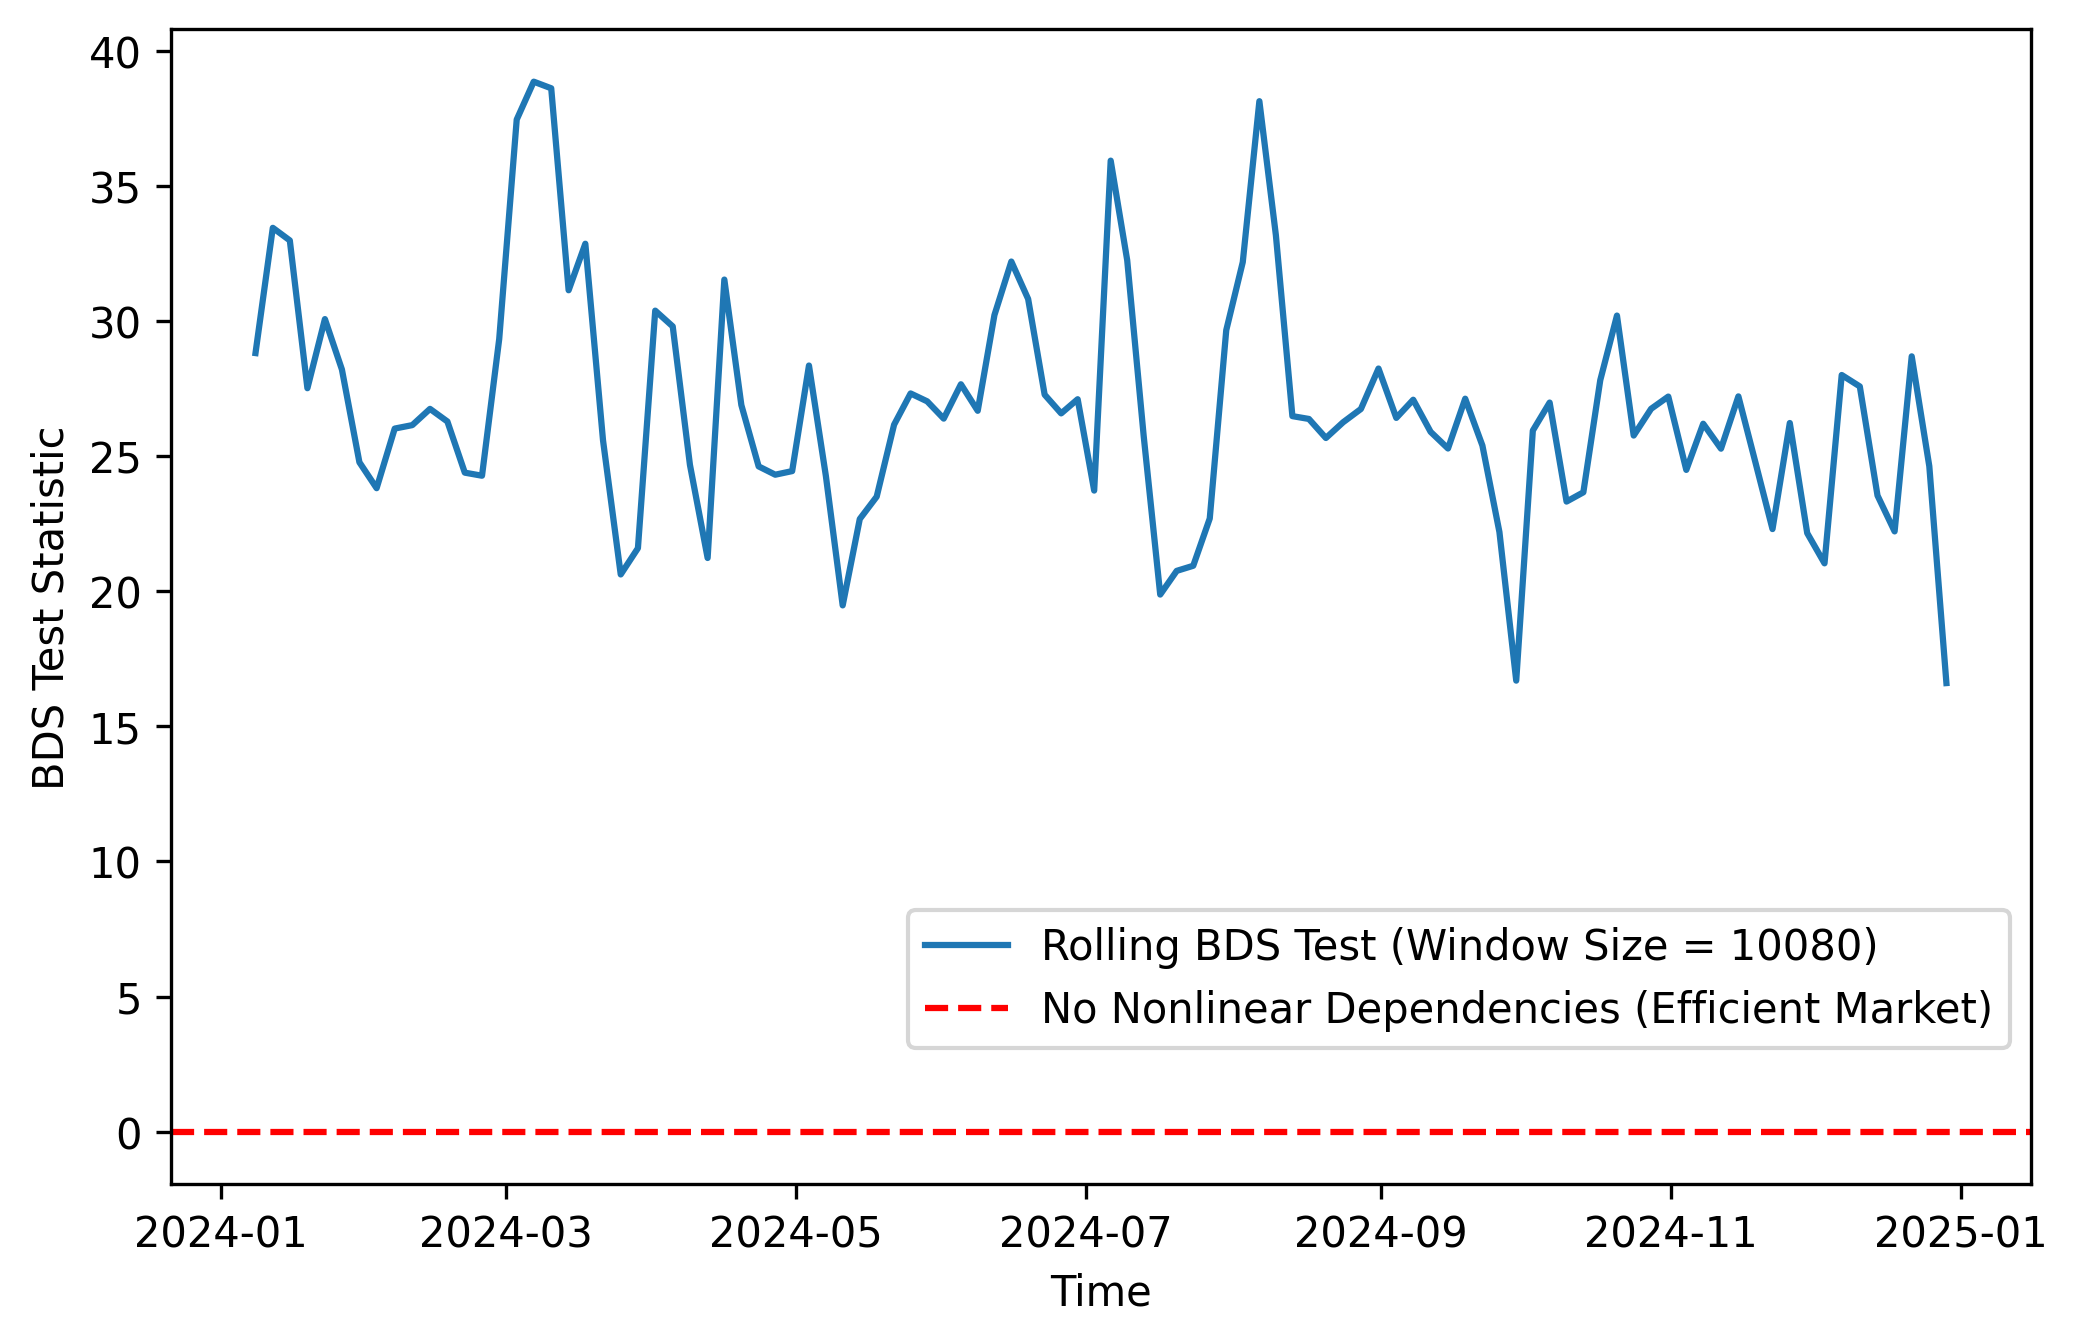

In [ ]:
# Plot rolling BDS test
plt.figure(figsize=(8, 5))
plt.plot(bds_df.index, bds_df['BDS_Stat'], label=f'Rolling BDS Test (Window Size = {window_size})')
plt.axhline(0, color='red', linestyle='--', label='No Nonlinear Dependencies (Efficient Market)')
plt.xlabel('Time')
plt.ylabel('BDS Test Statistic')
# plt.title('Rolling BDS Test for Nonlinear Dependencies in Bitcoin Returns')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1))  
plt.show()

In [26]:
# Findings: 
# 1. BDS Test Statistic is Consistently High (Far Above 0) -> ranges between ~15 and ~40 
# -> Bitcoin returns exhibit significant nonlinear dependencies throughout 2024.
# 2. No Periods Where the Market is Fully Efficient 
# -> past price movements contain hidden structures that could be exploited for trading.
# 3. Fluctuations in Nonlinear Dependencies 
# -> While inefficiencies persist throughout the year, the degree of inefficiency fluctuates.

# Hence, 
# Bitcoin is NOT weak-form efficient -> persistent nonlinear dependencies indicate that past returns contain information about future price movements.
# Trading Strategies May Exploit These Inefficiencies.
# Market Inefficiency Evolves Over Time -> dynamic efficiency. 